## Importing the dataset
We'll use pandas to read the dataset and load it into a dataframe.

In [1]:
#!pip install transformers
#!pip install torch

In [2]:
import numpy as np
import pandas as pd
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU, Embedding
from keras.callbacks import EarlyStopping, ModelCheckpoint
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')


Using TensorFlow backend.


In [3]:
import tensorflow as tf
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer, GPT2LMHeadModel


In [4]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = TFGPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)


All model checkpoint weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


For performance reasons, we'll only use 2,000 sentences from the dataset

In [5]:
L=200
fns = ['data/'+x for x in ['it/dev.en','koran/dev.en','law/dev.en','medical/dev.en','subtitles/dev.en']]
data = pd.concat([pd.read_csv(fn, delimiter='\t', header=None)[:L] for fn in fns])

batch_1 = data

In [7]:
data.head()

,0
0,nitrogen
1,"FIND( "" FindText "" ; "" Text "" ; Position)"
2,flowcharts
3,"Depending on the chart type, the texts are sho..."
4,On the Fly Operations (JPEG only)


In [8]:
Y = []
for i,l in enumerate([len(pd.read_csv(fn, delimiter='\t', header=None)) for fn in fns]):
    Y.extend(l*[i])

We can ask pandas how many sentences are labeled as "positive" (value 1) and how many are labeled "negative" (having the value 0)

## Loading the Pre-trained dilBERT model
Let's now load a pre-trained BERT model. 

In [9]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [10]:
ppb.DistilBertForMaskedLM


transformers.modeling_distilbert.DistilBertForMaskedLM

Right now, the variable `model` holds a pretrained distilBERT model -- a version of BERT that is smaller, but much faster and requiring a lot less memory.

## Model #1: Preparing the Dataset
Before we can hand our sentences to BERT, we need to so some minimal processing to put them in the format it requires.

### Tokenization
Our first step is to tokenize the sentences -- break them up into word and subwords in the format BERT is comfortable with.

In [11]:
tokenized = batch_1[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [12]:
len(batch_1)

1000

In [13]:
tokenizer.encode("stirring final read finally transporting re")

[101, 18385, 2345, 3191, 2633, 18276, 2128, 102]

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-tokenization-2-token-ids.png" />

### Padding
After tokenization, `tokenized` is a list of sentences -- each sentences is represented as a list of tokens. We want BERT to process our examples all at once (as one batch). It's just faster that way. For that reason, we need to pad all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths).

In [14]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
max_len = max(len(i) for i in tokenized.values)
padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

Our dataset is now in the `padded` variable, we can view its dimensions below:

In [15]:
np.array(padded).shape

(1000, 281)

### Masking
If we directly send `padded` to BERT, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. That's what attention_mask is:

In [16]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(1000, 281)

## Model #1: And Now, Deep Learning!
Now that we have our model and inputs ready, let's run our model!

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-tutorial-sentence-embedding.png" />

The `model()` function runs our sentences through BERT. The results of the processing will be returned into `last_hidden_states`.

In [17]:
%%time
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

CPU times: user 9min 27s, sys: 8min 12s, total: 17min 39s
Wall time: 13min 16s


Let's slice only the part of the output that we need. That is the output corresponding the first token of each sentence. The way BERT does sentence classification, is that it adds a token called `[CLS]` (for classification) at the beginning of every sentence. The output corresponding to that token can be thought of as an embedding for the entire sentence.

<img src="https://jalammar.github.io/images/distilBERT/bert-output-tensor-selection.png" />

We'll save those in the `features` variable, as they'll serve as the features to our logitics regression model.

In [18]:
features = last_hidden_states[0][:,0,:].numpy()

The labels indicating which sentence is positive and negative now go into the `labels` variable

In [19]:
X = np.transpose(features)

# PCA

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

random_state = 0


In [21]:
labels = [1]*L + [2]*L + [3]*L + [4]*L + [5]*L

In [22]:
print(X.shape)

(768, 1000)


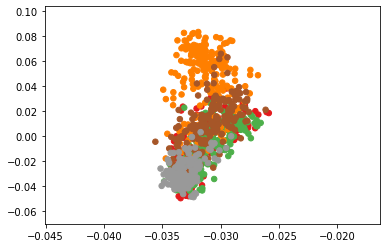

In [23]:
pca = PCA(n_components=2, random_state=random_state)
pca.fit(X)

plt.figure()

#X_embedded = model.transform(X)
#X_embedded = pca.transform(X)

# Plot the projected points and show the evaluation score
#plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, s=30, cmap='Set1')
plt.scatter(pca.components_[0], pca.components_[1], c=labels,  s=30, cmap='Set1')

#plt.title("{}, KNN (k={})\nTest accuracy = {:.2f}".format(name,
#                                                          n_neighbors,
#                                                          acc_knn))
plt.show()
